In [1]:
import ugradio
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import astropy
import scipy.signal
import cmasher
import glob
import barycorrpy
import cmasher as cmr

import cartopy.crs as ccrs
from cartopy.mpl.ticker import (LongitudeFormatter, LatitudeFormatter, LatitudeLocator, LongitudeLocator)
from scipy.signal import medfilt
%matplotlib widget

No module named 'rtlsdr'


In [2]:
phases = ['/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase1',
          '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2']
noise  = ['/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Noise_Spectra']
files = [file for directory in phases for file in glob.glob(f'{directory}/*.npz')]
noisefiles = [file for directory in noise for file in glob.glob(f'{directory}/*.npz')]


In [3]:
loadcols = ['L', 'B', 'RA', 'DEC', 'Galactic_Index']
df = pd.read_csv('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/Leusch_Stuff/RA_Sorted.csv',
                  usecols=loadcols)

In [4]:
df

,L,B,RA,DEC,Galactic_Index
0,124.4,20.0,23.851192,82.746098,168
1,124.4,23.4,32.778248,86.042542,169
2,129.0,20.0,52.084066,80.962227,180
3,133.6,20.0,69.006710,77.908980,192
4,129.0,23.4,69.993942,83.367395,181
...,...,...,...,...,...
319,115.2,23.4,309.232324,82.078465,145
320,110.6,20.0,312.501293,76.649154,132
321,115.2,20.0,326.412516,79.953801,144
322,119.8,23.4,334.954938,85.318438,157


#### Pointings for table 1 in paper.

In [5]:
latex_table = df.to_latex(index=False, header=True)
# print(latex_table)    # uncomment to see list of values, copy/paste into paper

In [6]:
leusch_coords = sorted(files, key=lambda x: np.load(x)['coords'][5])

In [7]:
leusch_coords[:5]

['/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2/spec292_L60_B20.npz',
 '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2/spec286_L60_B23.npz',
 '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2/spec277_L60_B27.npz',
 '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2/spec270_L60_B30.npz',
 '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase2/spec261_L60_B34.npz']

In [8]:
np.sort(files)
print(files[0])

/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase1/spec36_L170_B27.npz


In [9]:
print(len(leusch_coords))

292


In [54]:
'''
Params:
-------
• pwr0, pwr1: Our data, polarizations of 292 channels containing 2048 samples each.

'''

len_testdata = len(leusch_coords) 
pwr0 = [] 
pwr1 = []
unix = []
coordinates = []
alt_az = []
jd = []
galactic = []
ra       = []
dec      = []
ra_dec   = []
# missing  = []

# iterate through all 'testdata' object 
# grab info as well 
for n in range(len_testdata):
    test_dataFiles = np.load(leusch_coords[n])
    # spectra 
    pwr0.append(test_dataFiles["data0"]) # Append data
    pwr1.append(test_dataFiles["data1"])
    unix.append(test_dataFiles['time'][()])
    coordinates.append(test_dataFiles['coords'])
    galactic.append([test_dataFiles['coords'][1], test_dataFiles['coords'][2]])
    ra.append(  [test_dataFiles['coords'][3]])
    dec.append( [test_dataFiles['coords'][4]])
    ra_dec.append([test_dataFiles['coords'][3], test_dataFiles['coords'][4]])
    jd.append(test_dataFiles['jd'])
    # missing.append(test_dataFiles['missed'])
print(test_dataFiles)

NpzFile '/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Phase1/spec111_L180_B57.npz' with keys: data0, data1, time, missed, coords...


#### Frequency

In [189]:
freqs = 1420 + np.fft.fftshift(np.fft.fftfreq(len(pwr0[n]), 1/3.2))
# freqs = np.linspace(144, 156, ) + 1270

#### Galactic long, lat

In [11]:
l = [coordinates[0] for coordinates in galactic] # galactic lon
b = [coordinates[1] for coordinates in galactic] # galactic lat

In [12]:
print(len(galactic)) # both galactic l, b

292


#### Making map projection

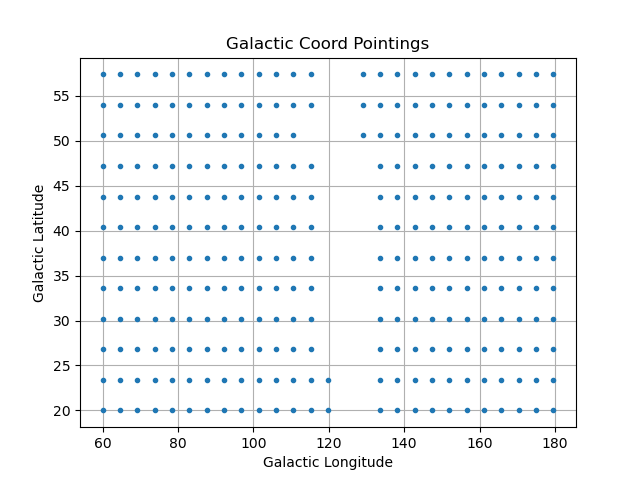

In [13]:
fig,ax = plt.subplots(1,1)
ax.plot(l, b, '.')
ax.set_xlabel('Galactic Longitude'), ax.set_ylabel('Galactic Latitude')
ax.set_title('Galactic Coord Pointings')
plt.grid(True)
plt.show()

In [14]:
print(f'min, max galactic longitude: {min(l), max(l)}')
print(f'min, max galactic latitude:  {min(b), max(b)}')

min, max galactic longitude: (60.0, 179.59999999999985)
min, max galactic latitude:  (20.0, 57.399999999999984)


In [15]:
glon = np.linspace(60, 200, 50)
glat = np.linspace(20, 60, 50)
ll, bb = np.meshgrid(glon, glat)

print('row: ', len(bb[:,0]))
print('col: ', len(bb[0,:]))

row:  50
col:  50


In [16]:
'''Making an empty matrix with the same row/cols as above.
   This will hold the information for the data collected 
   from our observations.'''

matrix = np.zeros((50, 50))

In [17]:
'''
• lb_val : holds our galactic coordinates
• indexes: where the index is located in our meshgrid array
'''
lb_val  = []
indexes = []


for i in range(len(ll[:,0])):
    for j in range(len(bb[0,:])):
        
        #HOLDING THE ROW INDEX
        row = i
        #HOLDS THE COLUMN INDEX
        column = j
        
        #HOLDS THE INDEX IN A LIST
        index = [i,j]
        
        #APPENDING THE VALUE FOR LL AND BB INTO THE [L,B] GALACTIC COORDINATES
        lb_val.append([ll[i,j], bb[i,j]])
        indexes.append(index)

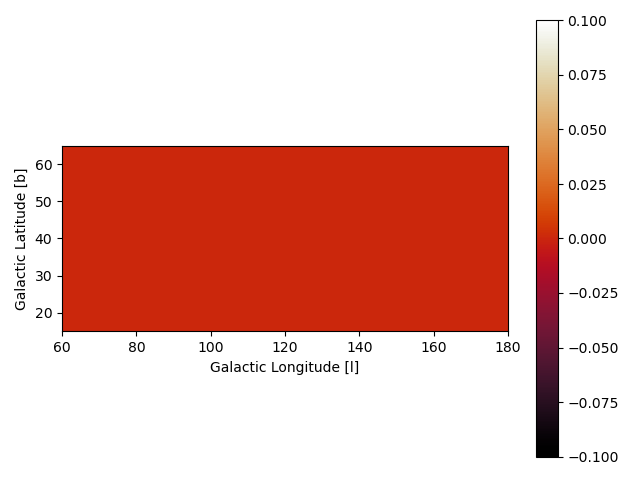

In [18]:
plt.figure()
plt.imshow(matrix, 
           interpolation='nearest',
           origin= 'lower',
           extent=[60, 180, 15, 65],
           cmap = cmr.sunburst
          )
plt.xlabel('Galactic Longitude [l]')
plt.ylabel('Galactic Latitude [b]')
plt.colorbar()
plt.tight_layout()
plt.show()

#### Map Building Continued & Functions

In [19]:
'''Building functions that automate the data collection and places them
   into the respective (l, b) on the above plot.
   
   Our actual galactic lon, lat data is stored in the following variables:
   • l : galactic longitude
   • b : galactic latitude 
   • jd: Julian dates associated with collected data pointings, might need
   '''


'Building functions that automate the data collection and places them\n   into the respective (l, b) on the above plot.\n   \n   Our actual galactic lon, lat data is stored in the following variables:\n   • l : galactic longitude\n   • b : galactic latitude \n   • jd: Julian dates associated with collected data pointings, might need\n   '

In [20]:
def shift(data):
    return np.fft.fftshift(data)

def gain(s_cal, s_cold):
    '''
    GET CALIBRATION DATA
    
    Params
    ------
    s_cal:  calibrated data, this is the data with noise diode turned on.
    s_cold: non-calibrated data, Leuschner pointed at arb. point.
    
    Output
    ------
    Gain calculated for Leuschner, we mult. all power spectra by this value.
    
    '''
    T_cal  = 30 # K
    T_cold = 2.73 # K
    
    difference = s_cal - s_cold
    G = ((T_cal - T_cold) / (np.sum(difference))) * np.sum(s_cold)
    return G

In [23]:
def T_power(line, G):
    '''This function calculates the intensity of the power spectrum
       given the spectrum and gain value.
       
       Params
       --------
       line: the spectrum we will multiply by the gain.
       G   : the gain of Leuschner 
       
       Output
       --------
       power: the final calibrated intensity of the object in
              units of temperature.
       '''
    intensity = line * G
    return intensity
    

In [24]:
'''This code just sums all the spectra within the the pol0, pol1 data arrays
   can use sum function instead to effectively do the same thing.'''
# # Initialize accumulators
# # Assuming you can get the shape from the first file
# initial_file = np.load(files[0])
# data = np.zeros_like(initial_file['data0'])
# data_pol = np.zeros_like(initial_file['data1'])

# # Process each file
# for file_path in files:
#     npz_file = np.load(file_path)
#     for key in sorted(npz_file.keys()):
#         if 'data0' in key:
#             data += npz_file[key]
#         elif 'data1' in key:
#             data_pol += npz_file[key]

# # Now 'data' and 'data_pol' contain the sum from all files


'This code just sums all the spectra within the the pol0, pol1 data arrays\n   can use sum function instead to effectively do the same thing.'

In [26]:
print(sum(pwr0))

[4.40489476e+11 1.89837933e+09 4.72331987e+08 ... 2.13076773e+08
 4.14726817e+08 1.43041625e+09]


In [317]:
# def data(hdu):
#     """
#     Function calculates the avg. power spectrum from the N samples
#     collected. The purpose is the reduce the noise in the power spectra.
    
#     Params:
#     -------
#     • hdu: data we attempt to avg. the power for.
#     • N  : number of integrated samples collected.
    
#     Output:
#     -------
#     • average: averaged power spectrum over N samples
#     """
#     N = len(hdu)
#     nu_samp = 3.2e6 # Hz, this was taken from our data collection script
    
#     M = 1 # counting variable
#     # data = 0
#     # data_pol = 0
#     while M <= N:
#         initial_file = np.load(files[M])
#         data = np.zeros_like(initial_file['data0'])
#         data_pol = np.zeros_like(initial_file['data1'])

#         # Process each file
#         for file_path in files:
#             npz_file = np.load(file_path)
#             for key in sorted(npz_file.keys()):
#                 if 'data0' in key:
#                     data += npz_file[key]
#                 elif 'data1' in key:
#                     data_pol += npz_file[key]
    
#     avg = data / N
#     avg_pol - data_pol / N
    
#     # avg between polarizations
#     sum_avg = (avg + avg_pol) / 2
#     spec = medfilt(sum_avg, kernal_size = 5)
    
#     return spec

In [169]:
'''
  Removing outliers from our data and smoothing overall
  
  Params: 
  -------
  • spec_test:  holds our reduced noise data for both polarizations. ----- this is what is returned
                and will be used to determine brightness temp, spec_test * gain
  • N:          length of the total amount of spectra collected, in this case 292 spectra.
  • avg0, avg1: contains data for pols 0, 1 respectively with reduced noise.

'''

spec_line = []
for i in range(len(pwr0)):
    N = len(pwr0)
    avg0 = pwr0[i] / N
    avg1 = pwr1[i] / N
    
    sum_avg = (avg0 + avg1) / 2
    spec = medfilt(sum_avg, kernel_size=5)
    spec_line.append(spec)



# spec_test = []  # List to store the spectrum for each array

# for i in range(len(pwr0)):
#     # Calculate the average of each array
#     avg0 = np.mean(pwr0[i])
#     avg1 = np.mean(pwr1[i])
    
#     # Calculate the average of the two averages
#     sum_avg = (avg0 + avg1) / 2
    
#     # Median filter the average and append to spec
#     filtered_spec = medfilt(sum_avg, kernel_size=5)  # Assuming a kernel size
#     spec_test.append(filtered_spec)

# Now spec contains the processed spectra for each array


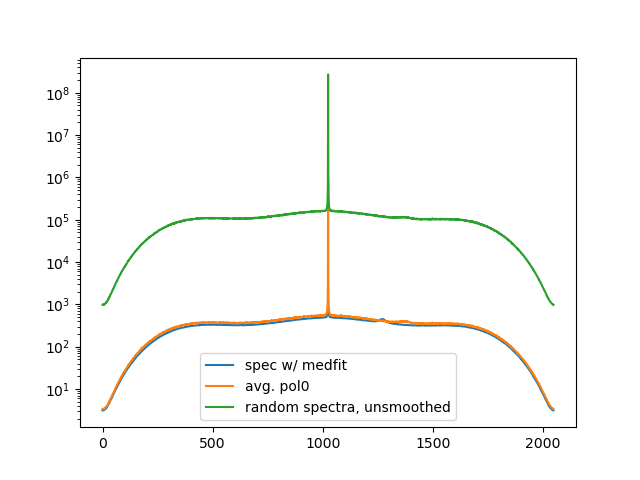

In [170]:
plt.figure()
plt.semilogy(shift(spec_line[0]), label='spec w/ medfit')
plt.semilogy(shift(avg0), label='avg. pol0')
plt.semilogy(shift(pwr0[291]), label='random spectra, unsmoothed')
plt.legend()
plt.show()

In [171]:
print(len(spec_line[0]), len(spec_line))

2048 292


#### Calibration: Gain & Brightness Temp

In [100]:
cal_data0 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Noise_Spectra/NoiseSpec165_L111_B57.npz')['data0']
cold_data0 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042524/coldspec.npz')['data0']

cal_data1 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042424/Noise_Spectra/NoiseSpec165_L111_B57.npz')['data1']
cold_data1 = np.load('/Users/rs_mbpro14/Desktop/Astro Courses/RadioLab/Lab4/ay121_2024_lab4/FFC_4-main/data/obs_042524/coldspec.npz')['data1']

In [150]:
'''
Determining Gain using both polarizations

• N: the length of our collected spectra data, in this case 292. This is used to reduce noise.


'''

_cal0  = cal_data0 / N
_cold0 = cold_data0 / N

_cal1 = cal_data1 / N
_cold1 = cold_data1 / N

avg_calspec = (_cal0 + _cal1) / 2
avg_coldspec = (_cold0 + _cold1) / 2

G = gain(avg_calspec, avg_coldspec)
print(f'Gain: {G}')

# spec_gain = spec_test[0] * G # for testing

Gain: 24.155442501681158
[20681.95181641 20681.95181641 20681.95181641 ... 15510.38708647
 15510.38708647 15510.38708647]
2048


In [172]:
'''
Here we determine the brightness temperature of all spectra
by multiplying all spectra by the gain.

Params
------
• spec_line: contains all original reduced noise spectra
• calibrated_spec: contains all calibrated spectra taking into account the gain, i.e. brightness temp
'''

calibrated_spec = []
for i in range(len(pwr0)):
    spectra = spec_line[i] * G
    calibrated_spec.append(spectra) # brightness temp [K]
    
'''Removing central spike'''
calibrated_spec[980:]

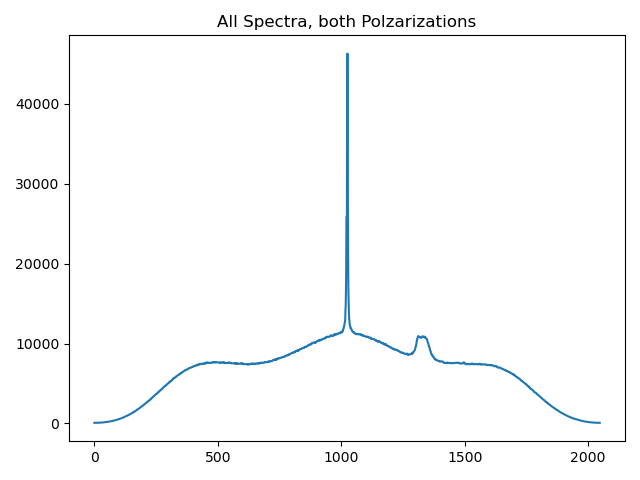

In [185]:
plt.figure()
# plt.semilogy(shift(calibrated_spec), label=f'Spectra * Gain \nGain: {G}')
# plt.plot(shift(calibrated_spec[150]) - np.median(calibrated_spec))
plt.plot(shift(calibrated_spec[150]) )

# plt.legend(loc='upper right')
plt.title('All Spectra, both Polzarizations')
plt.tight_layout()
plt.show()

In [ ]:
# ind = []
# freq_peak = []

# for i in range(len(pwr0)):
#     index = np.nanargmax(spec_line[i])
#     ind.append(index)
#     freq_peak(freqs)

In [126]:
'''May make use of this...'''

# x_arr = np.linspace(min(l), max(l), 200)
# y_arr = np.linspace(min(b), max(b), 200)

# X0 =  0
# Y0 = -8
# X, Y = np.meshgrid(x_arr, y_arr)

# vel_x = np.array( Y / np.sqrt(X**2 + Y**2) * 220) # 220 km/s velocity of galactic arm
# vel_y = np.array(-X / np.sqrt(X**2 + Y**2) * 220)
# vel_earth_x = Y0 / np.sqrt(Y0**2) * 220

# dx = X - 0
# dy = Y - 8

# vel_x_adjust = vel_x - vel_earth_x
# velocity = vel_x_adjust, vel_y

# r_vector = dx, dy
# mag_r = (np.sqrt(dx**2 + dy**2))
# mag_r_x_c = mag_r * 3e5          # c = 3e5 km/s

# dx_unit = dx / mag_r
# dy_unit = dy / mag_r

# vel_away = vel_x_adjust * dx_unit + vel_y * dy_unit # dν
# lon_model_rad = np.arctan2(-dx, dy)
# lon_model_deg = np.rad2deg(lon_model_rad)

In [121]:
# for i in range(len(lon_model_deg)):
#     for j in range(len(lon_model_deg[i])):
#         if lon_model_deg[i][j] < -110:
#             lon_model_deg[i][j] += 360

In [125]:
# plt.figure()
# plt.imshow(vel_away, 
#            interpolation='nearest',
#            origin= 'lower',
#            cmap = cmr.sunburst
#           )
# plt.colorbar()
# plt.show()

#### projected velocities

In [36]:
# ugradio.doppler.get_projected_velocity??
doppler_v = ugradio.doppler.get_projected_velocity(ra = ra, dec = dec, jd = jd)
for i in range(len(coordinates)):
    print(ra[i], dec[i], np.mean(doppler_v[i]))

[275.4099465006669] [32.44704573697857] 14859.542922909723 m / s
[271.57775804742187] [33.55743568956647] 13597.070386923688 m / s
[267.65132671741213] [34.546814588456684] 12286.74770921859 m / s
[263.6366826665167] [35.407641930429385] 10933.187676566678 m / s
[259.5423120404737] [36.13293452571155] 9541.155286118705 m / s
[255.37913877895232] [36.716478476806486] 8115.550970959397 m / s
[251.16036251726064] [37.15303984043927] 6661.393348907927 m / s
[246.9011415541328] [37.438558605176524] 5183.801555234918 m / s
[242.61812746349955] [37.57030979885039] 3687.977221574969 m / s
[238.32887768577496] [37.547016913593694] 2179.186164380279 m / s
[234.05119045539212] [37.368906516953736] 662.739847421845 m / s
[229.80241862952712] [37.03769848983667] -856.0233163740755 m / s
[277.1869841999899] [36.51398989903068] 13680.727371236302 m / s
[273.1424702704984] [37.58271117219223] 12445.77537678549 m / s
[268.988149184952] [38.50961825161651] 11167.02619526655 m / s
[264.73445503350337] [3

#### Building Official Map

In [47]:
spec

array([94469181.4544125 , 94469181.4544125 , 24367155.62426463, ...,
       11687604.34153227, 21775097.06831199, 21775097.06831199])